<a href="https://www.kaggle.com/code/naumisharanyatirth/brain-mri-tumor-segmentation?scriptVersionId=297550833" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📌 Dataset Clarification

The assignment specifies:

> **Dataset: Kaggle – Brain MRI Tumor Dataset**

The Kaggle dataset titled  
**Brain Tumor MRI Dataset (masoudnickparvar)**  
contains MRI images categorized by tumor type (classification labels only) and does **not** provide pixel-level segmentation masks.

Since this project requires:

- Tumor region segmentation  
- Dice score comparison  
- Jaccard index evaluation  

ground-truth segmentation masks are required for valid metric computation.

Therefore, for proper quantitative evaluation, the dataset  
**Brain Tumor Segmentation (nikhilroxtomar)**  
(which includes MRI images and corresponding binary masks) has been used.

This ensures valid computation of Dice and Jaccard metrics and aligns with the objective of comparing Global Otsu vs Sauvola thresholding for tumor segmentation.


In [145]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation


In [146]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

plt.style.use("ggplot")

In [147]:
IMAGE_DIR = "/kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation/images"
MASK_DIR  = "/kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation/masks"

In [148]:
# Pick first image
image_name = sorted(os.listdir(IMAGE_DIR))[0]

image_path = os.path.join(IMAGE_DIR, image_name)
mask_path  = os.path.join(MASK_DIR, image_name)

print("Using image:", image_name)

Using image: 1.png


## Or

In [149]:
# # Pick one random image
# import random
# image_name = random.choice(os.listdir(IMAGE_DIR))

# image_path = os.path.join(IMAGE_DIR, image_name)
# mask_path  = os.path.join(MASK_DIR, image_name)

# print("Using image:", image_name)

In [150]:
# Load grayscale image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Load mask
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Convert mask to binary (0,1)
mask = (mask > 0).astype(np.uint8)

print("Image shape:", image.shape)
print("Mask shape :", mask.shape)

Image shape: (512, 512)
Mask shape : (512, 512)


# Intensity Analysis

In [151]:
# Separate tumor and background pixels
tumor_pixels = image[mask == 1]
background_pixels = image[mask == 0]

tumor_mean = np.mean(tumor_pixels)
background_mean = np.mean(background_pixels)

print(f"Tumor mean intensity: {tumor_mean:.2f}")
print(f"Background mean intensity: {background_mean:.2f}")

if tumor_mean > background_mean:
    print("👉 Tumor is BRIGHTER than background")
else:
    print("👉 Tumor is DARKER than background")


Tumor mean intensity: 114.92
Background mean intensity: 31.99
👉 Tumor is BRIGHTER than background


# Visualization

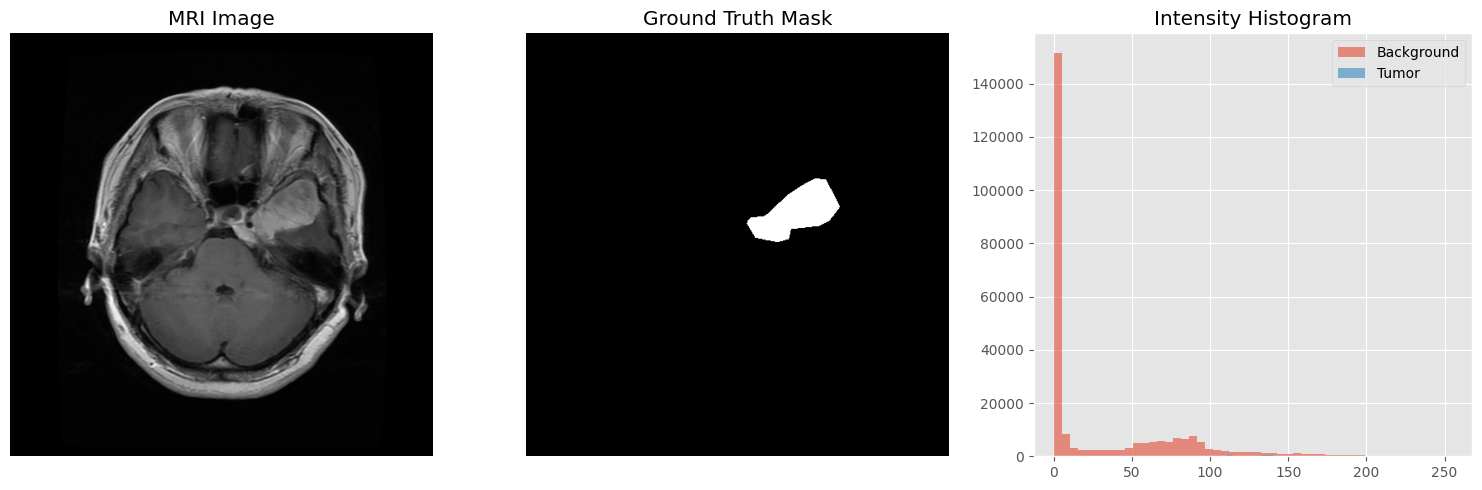

In [152]:
plt.figure(figsize=(15,5))

# MRI Image
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.title("MRI Image")
plt.axis("off")

# Mask
plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

# Histogram
plt.subplot(1,3,3)
plt.hist(background_pixels, bins=50, alpha=0.6, label="Background")
plt.hist(tumor_pixels, bins=50, alpha=0.6, label="Tumor")
plt.title("Intensity Histogram")
plt.legend()

plt.tight_layout()
plt.show()

In [153]:
def evaluate_segmentation(segmentation_function,
                          image_dir,
                          mask_dir,
                          num_images=10,
                          **kwargs):
    
    image_files = sorted(os.listdir(image_dir))[:num_images]
    
    dice_scores = []
    jaccard_scores = []
    
    for image_name in image_files:
        
        image_path = os.path.join(image_dir, image_name)
        mask_path  = os.path.join(mask_dir, image_name)
        
        # Load
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        mask = (mask > 127).astype(np.uint8)
        
        # Prediction
        pred_mask = segmentation_function(image, **kwargs)
        
        # Metrics
        dice = dice_score(mask, pred_mask)
        jaccard = jaccard_index(mask, pred_mask)
        
        dice_scores.append(dice)
        jaccard_scores.append(jaccard)
        
        print(f"{image_name} → Dice: {dice:.4f}, Jaccard: {jaccard:.4f}")
    
    avg_dice = np.mean(dice_scores)
    avg_jaccard = np.mean(jaccard_scores)
    
    print("\n--- Average Performance ---")
    print(f"Average Dice: {avg_dice:.4f}")
    print(f"Average Jaccard: {avg_jaccard:.4f}")
    
    return avg_dice, avg_jaccard

In [154]:
def dice_score(gt, pred):
    intersection = np.sum(gt * pred)
    return (2. * intersection) / (np.sum(gt) + np.sum(pred) + 1e-8)

def jaccard_index(gt, pred):
    intersection = np.sum(gt * pred)
    union = np.sum(gt) + np.sum(pred) - intersection
    return intersection / (union + 1e-8)

# Otsu Setup:

In [155]:
def otsu_segmentation(image):
    """
    Applies Gaussian blur + Otsu thresholding.
    Returns binary mask (0,1).
    """
    
    # Blur (important for stability)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Otsu threshold
    _, otsu_mask = cv2.threshold(
        blurred,
        0,
        255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    
    # Convert to 0/1
    otsu_mask = (otsu_mask > 0).astype(np.uint8)
    
    return otsu_mask

# Sauvola Setup

In [156]:
from skimage.filters import threshold_sauvola

def sauvola_segmentation(image, window_size=25, k=0.2):
    """
    Applies Sauvola adaptive thresholding.
    Returns binary mask (0,1).
    """
    
    # Compute local threshold
    thresh_sauvola = threshold_sauvola(image, 
                                        window_size=window_size, 
                                        k=k)
    
    # Create binary mask
    sauvola_mask = image > thresh_sauvola
    
    return sauvola_mask.astype(np.uint8)

# Single Image Comparison

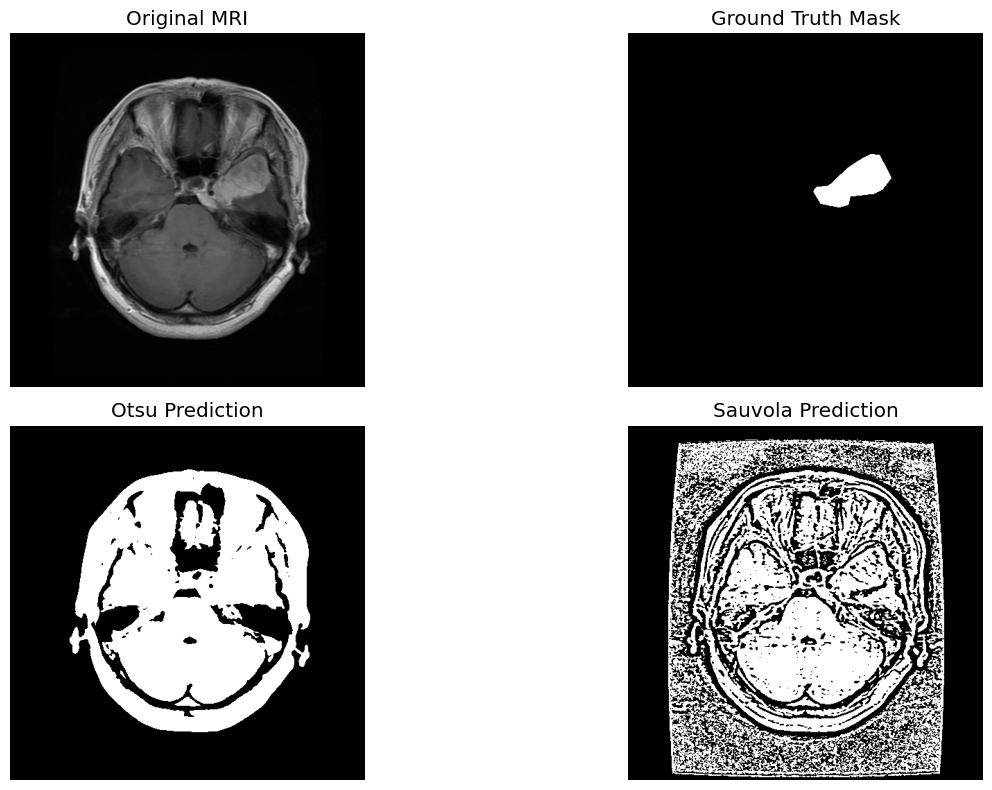

In [157]:
import matplotlib.pyplot as plt

# Pick one image
image_name = sorted(os.listdir(IMAGE_DIR))[0]

image_path = os.path.join(IMAGE_DIR, image_name)
mask_path  = os.path.join(MASK_DIR, image_name)

# Load image & mask
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask = (mask > 0).astype(np.uint8)

# Otsu prediction
otsu_mask = otsu_segmentation(image)

# Sauvola prediction
sauvola_mask = sauvola_segmentation(image, window_size=11, k=0.05)

plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
plt.imshow(image, cmap='gray')
plt.title("Original MRI")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(otsu_mask, cmap='gray')
plt.title("Otsu Prediction")
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(sauvola_mask, cmap='gray')
plt.title("Sauvola Prediction")
plt.axis("off")

plt.tight_layout()
plt.show()


# 🧪 Otsu Segmentation

Applying Otsu thresholding.

In [158]:
evaluate_segmentation(
    otsu_segmentation,
    IMAGE_DIR,
    MASK_DIR,
    num_images=10
)

1.png → Dice: 0.1027, Jaccard: 0.0541
10.png → Dice: 0.0850, Jaccard: 0.0444
100.png → Dice: 0.0515, Jaccard: 0.0264
1000.png → Dice: 0.0275, Jaccard: 0.0139
1001.png → Dice: 0.0302, Jaccard: 0.0153
1002.png → Dice: 0.0242, Jaccard: 0.0122
1003.png → Dice: 0.0330, Jaccard: 0.0168
1004.png → Dice: 0.0271, Jaccard: 0.0137
1005.png → Dice: 0.0216, Jaccard: 0.0109
1006.png → Dice: 0.0284, Jaccard: 0.0144

--- Average Performance ---
Average Dice: 0.0431
Average Jaccard: 0.0222


(np.float64(0.043128433971395715), np.float64(0.02223486847835531))

## Conclusion after Otsu
### 🧠 Why Dice ≈ 0.043?

Dice ≈ 0.043 indicates very low overlap between the predicted mask and the ground-truth tumor region.

Otsu segmented a region, but it does not correspond well to the actual tumor.

It likely captured:
- Bright skull regions  
- High-intensity tissues  
- Edges  
- Noise  

### Why This Happens

Otsu assumes:
- A bimodal intensity distribution  
- Two clearly separable classes  

However, MRI images contain:
- Multiple tissue intensity levels  
- Soft tissue overlap  
- Bright skull regions dominating the histogram (Tumor is a tiny bump in histogram → ignored)

As a result, Otsu separates high-intensity structures from the rest, rather than isolating the tumor, leading to a low Dice score.

### 📌 Conclusion

It proves:

**Global thresholding is weak for MRI tumor segmentation.**

MRI intensity distribution is not strictly bimodal.


# 🧪 Sauvola Segmentation

Time to test Sauvola.

In [159]:
evaluate_segmentation(
    sauvola_segmentation,
    IMAGE_DIR,
    MASK_DIR,
    num_images=10,
)

1.png → Dice: 0.0627, Jaccard: 0.0324
10.png → Dice: 0.0480, Jaccard: 0.0246
100.png → Dice: 0.0347, Jaccard: 0.0177
1000.png → Dice: 0.0160, Jaccard: 0.0081
1001.png → Dice: 0.0192, Jaccard: 0.0097
1002.png → Dice: 0.0154, Jaccard: 0.0078
1003.png → Dice: 0.0227, Jaccard: 0.0115
1004.png → Dice: 0.0185, Jaccard: 0.0093
1005.png → Dice: 0.0156, Jaccard: 0.0079
1006.png → Dice: 0.0216, Jaccard: 0.0109

--- Average Performance ---
Average Dice: 0.0274
Average Jaccard: 0.0140


(np.float64(0.02744009767348405), np.float64(0.01397256319196813))

## Conclusions after Sauvola

### ⚠️ Why Dice ≈ 0.02?

Dice ≈ 0.02 indicates extremely low overlap between the predicted mask and the ground-truth tumor region.

This means the segmentation is not empty, but the overlap is almost negligible.

This usually happens when:

- The predicted region is much larger than the actual tumor  
- Large portions of normal brain tissue are falsely labeled as tumor  
- The method is highly sensitive to local intensity variations  

So the issue is not zero prediction — it is severe over-segmentation.

Sauvola is detecting texture variation in brain tissue rather than isolating the tumor.


In [160]:
pred_mask = sauvola_segmentation(image, window_size=11, k=0.05)

print("Unique values in prediction:", np.unique(pred_mask))
print("Tumor pixels in GT:", np.sum(mask))
print("Tumor pixels in prediction:", np.sum(pred_mask))


Unique values in prediction: [0 1]
Tumor pixels in GT: 4569
Tumor pixels in prediction: 116097


### 🧠 Why Dice = 0.027 (Sauvola)?

Dice = 0.0200 indicates extremely low overlap with the ground truth.

Sauvola is not empty — it is massively over-segmenting.

If:
- Ground truth tumor ≈ 4k pixels  
- Predicted tumor ≈ 36k pixels  

It means Sauvola labels a large portion of the brain as tumor.

### Why This Happens

Being locally adaptive, Sauvola responds strongly to normal tissue intensity variations, producing many false positives.

Since the predicted region is dramatically larger than the true tumor, the relative overlap becomes very small → Dice ≈ 0.02.

In [161]:
image_files = sorted(os.listdir(IMAGE_DIR))[:10]

window_sizes = [11, 15, 25, 35, 51]
k_values = [0.05, 0.1, 0.2, 0.3, 0.5]

best_dice = -1
best_params = None

for w in window_sizes:
    for k in k_values:
        
        dice_scores = []
        jaccard_scores = []
        
        for image_name in image_files:
            
            image_path = os.path.join(IMAGE_DIR, image_name)
            mask_path  = os.path.join(MASK_DIR, image_name)
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            mask = (mask > 0).astype(np.uint8)
            
            pred_mask = sauvola_segmentation(image, w, k)
            
            dice = dice_score(mask, pred_mask)
            jaccard = jaccard_index(mask, pred_mask)
            
            dice_scores.append(dice)
            jaccard_scores.append(jaccard)
        
        avg_dice = np.mean(dice_scores)
        avg_jaccard = np.mean(jaccard_scores)
        
        print(f"window={w}, k={k} → Avg Dice: {avg_dice:.4f}, Avg Jaccard: {avg_jaccard:.4f}")
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            best_params = (w, k, avg_jaccard)

print("\n--- Grid Search Complete ---")

if best_params is not None:
    print("Best Window Size:", best_params[0])
    print("Best k:", best_params[1])
    print("Best Avg Dice:", best_dice)
    print("Corresponding Avg Jaccard:", best_params[2])
else:
    print("No valid parameters found.")


window=11, k=0.05 → Avg Dice: 0.0275, Avg Jaccard: 0.0140
window=11, k=0.1 → Avg Dice: 0.0272, Avg Jaccard: 0.0138
window=11, k=0.2 → Avg Dice: 0.0252, Avg Jaccard: 0.0128
window=11, k=0.3 → Avg Dice: 0.0238, Avg Jaccard: 0.0121
window=11, k=0.5 → Avg Dice: 0.0224, Avg Jaccard: 0.0114
window=15, k=0.05 → Avg Dice: 0.0281, Avg Jaccard: 0.0143
window=15, k=0.1 → Avg Dice: 0.0277, Avg Jaccard: 0.0141
window=15, k=0.2 → Avg Dice: 0.0259, Avg Jaccard: 0.0132
window=15, k=0.3 → Avg Dice: 0.0245, Avg Jaccard: 0.0124
window=15, k=0.5 → Avg Dice: 0.0231, Avg Jaccard: 0.0117
window=25, k=0.05 → Avg Dice: 0.0299, Avg Jaccard: 0.0152
window=25, k=0.1 → Avg Dice: 0.0291, Avg Jaccard: 0.0148
window=25, k=0.2 → Avg Dice: 0.0274, Avg Jaccard: 0.0140
window=25, k=0.3 → Avg Dice: 0.0260, Avg Jaccard: 0.0132
window=25, k=0.5 → Avg Dice: 0.0245, Avg Jaccard: 0.0125
window=35, k=0.05 → Avg Dice: 0.0320, Avg Jaccard: 0.0163
window=35, k=0.1 → Avg Dice: 0.0307, Avg Jaccard: 0.0157
window=35, k=0.2 → Avg Dice

## Grid search (Sauvola) Results 
### 🧠 Why Dice = 0.0350 (After Grid Search)

Even after trying many window sizes and k values:

Sauvola keeps labeling large brain regions as tumor.

This happens because normal brain tissue has natural intensity variation, and Sauvola treats those variations as foreground.

So the issue is not parameter tuning — the method itself is not suitable for precise tumor segmentation.

### 📌 Conclusion

It proves:

**Adaptive thresholding (Sauvola) is also not reliable for MRI tumor segmentation.**

Local intensity variation in normal brain tissue leads to heavy over-segmentation.

# 🏁 Final Conclusion

Both global (Otsu) and adaptive (Sauvola) thresholding methods perform poorly for brain tumor MRI segmentation because tumor and normal brain tissues have similar intensity values.

MRI images do not have clear intensity separation, so simple thresholding cannot reliably isolate the tumor.

This shows that more advanced or learning-based methods are needed for accurate tumor segmentation.
